### Incompressible two phase flow in 1D

Two continuity equations,

Water:
$$ \frac{\partial}{\partial t}\left(\phi S_{w}\rho_{w}\right) + \nabla\cdot\left(\rho_{w}\mathbf{v}_{w}\right) = \rho_{w}q_{w} $$
Oil:
$$ \frac{\partial}{\partial t}\left(\phi S_{n}\rho_{n}\right) + \nabla\cdot\left(\rho_{n}\mathbf{v}_{n}\right) = \rho_{n}q_{n} $$

The sum of the saturation equals 1,
$$ S_{n} + S_{w} = 1 $$
The capiliary pressure is given by,
$$ p_{c} = p_{n} - p_{w} $$

The velocities are then given by (Darcy flwo),

Water:
$$ \mathbf{v}_{w} = \frac{Kk_{rw}}{\mu_{w}}\left(\nabla p_{n} - \nabla p_{c} - \rho_{w}g\nabla z \right) $$
Oil:
$$ \mathbf{v}_{n} = \frac{Kk_{rn}}{\mu_{n}}\left(\nabla p_{n} - \rho_{n}g\nabla z \right) $$

Which means I can write:

Water:
$$ \frac{\partial}{\partial t}\left(\phi S_{w}\rho_{w}\right) + \nabla\cdot\left(\frac{\rho_{w}Kk_{rw}}{\mu_{w}}\left(\nabla p_{n} - \nabla p_{c}(S_{w}) - \rho_{w}g\nabla z \right)\right) = \rho_{w}q_{w} $$
Oil:
$$ \frac{\partial}{\partial t}\left(\phi S_{n}\rho_{n}\right) + \nabla\cdot\left(\frac{\rho_{n}Kk_{rn}}{\mu_{n}}\left(\nabla p_{n} - \rho_{n}g\nabla z \right)\right) = \rho_{n}q_{n} $$

Define: $$\lambda = \frac{\rho k_{r}}{\mu} $$

Assume incompressible, such that densities are constant and porosity is a function of space only. Calculate total velocity:
$$ \mathbf{v} = \mathbf{v}_{w} + \mathbf{v}_{n}$$
which gives,
$$ \mathbf{v} = -\left(\lambda_{n}+\lambda_{w}\right)\nabla p_{n} + \lambda_{w} \nabla p_{c} + \left(\lambda_{n}\rho_{n} + \lambda_{w}\rho_{w}\right)g\nabla z $$

Take the sum of the continuity equations (porosity is a function of space only):
$$ \phi\frac{\partial}{\partial t}\left(S_{w}+S_{n}\right) + \nabla\cdot\left(\mathbf{v}_{w} + \mathbf{v}_{n}\right) = q_{w} + q_{n} $$
which gives,
$$ \nabla\cdot\mathbf{v} = q_{w} + q_{n} $$

Define mobility:
$$ \mathbf{\lambda} = \mathbf{\lambda}_{w} + \mathbf{\lambda}_{n} = \lambda K $$

Therefore if I subsitute for $\mathbf{v}$ using Darcy flow I get,
$$ -\nabla\cdot\left(\lambda K\nabla p_{n}\right) = q_{w} + q_{n} - \nabla\left(\mathbf{\lambda}_{w}\nabla p_c + \left(\mathbf{\lambda}_{w}\rho_{w} + \mathbf{\lambda}_{n}\rho_{n}\right)g\nabla z\right) $$

The only unkown here is $p_{n}$ if I assume there is some equation that gives us the capiliary pressure $p_{c}$ and the reduced permeability $k_{r}$. Everything else is either an initial condition or a parameter we can set. From $p_{n}$ I can get $v_{w}$ and $S_{w}$.

###  Capiliary pressure and reduced permeability

Capiliary pressure is a function of the water saturation: $$ p_{c} = P_{c}(S_{w}) $$
In the oil industry it is extrapolated from well log information.

Reduced premeability is a function of saturation and is between 0 and 1. I assume it takes a power law form, $$ k_{r} = k_{0}S^n $$

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Lets make up a function for capiliary pressure:

In [2]:
def capiliary_pressure(Sw):
    Pc = 1e4/(Sw + 1e-10) # no divide by zero
    Pc[np.where(Pc > 1e5)] = 1e5
    return Pc

Function for the reduced permeability:

In [3]:
def reduced_permeability(S,n):
    kr = np.power(S,n)
    return kr

Test case: box 10 km by 20 km deep. Solve for pressure with Fenics:
$$ -\nabla\cdot\left(\lambda K \nabla p_{n}\right) + \left[q_{w}+q_{n}-\nabla\left(\mathbf{\lambda}_{w}\nabla p_c + \left(\mathbf{\lambda}_{w}\rho_{w} + \mathbf{\lambda}_{n}\rho_{n}\right)g\nabla z\right)\right] = 0 $$
which will become:
$$ \lambda K \nabla^{2} p_{n} + f = 0 $$

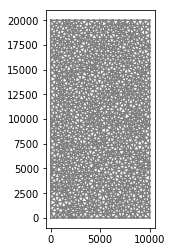

In [4]:
from fenics import *
from mshr import *

# define constants

K = 1e-10  # permeability constant (m-2)
g = 9.81  # gravity (ms-2)
rho_w = 1000  # density of water (kgm-3)
mu_w = 8.9e-4 # viscosity of water (Pas)
n_w = 2
rho_oil = 930  # density of oil (kgm-3)
mu_oil = 2e-3  # viscosity of oil (Pas)
n_oil = 2

# create domain

lx = 1e4  # 10 km long
lz = 2e4  # 20 km deep
res = 28  # resolution
domain = Rectangle(Point(0,0), Point(lx,lz))
mesh = generate_mesh(domain,res)

plt.figure()
plot(mesh)
plt.show()

I have my mesh, now define the trail function and boundary conditions.

In [5]:
V = FunctionSpace(mesh,'CG',2)
    
# Define boundary condition and intial condition

p_D = Constant(0)
 
class East(SubDomain):
    def inside(self, x , on_boundary):
        return near(x[0], lx)
    
class West(SubDomain):
    def inside(self, x , on_boundary):
        return near(x[0], 0.0)
    
class North(SubDomain):
    def inside(self, x , on_boundary):
        return near(x[1], lz)
    
class South(SubDomain):
    def inside(self, x , on_boundary):
        return near(x[1], 0.0)
    
bc = [DirichletBC(V, p_D, South())]

Define an initial condition for the pressure and saturation

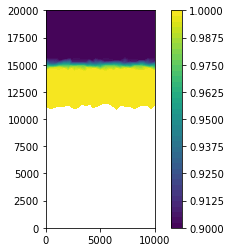

In [6]:
#S_w_D = Expression('x[1]>=0.75*lz ? 0.1 : 0.01',lz=lz,degree=2)
S_w_D = Expression('1-.1/(1+exp(-.01*(x[1]-.75*lz)))',lz=lz,degree=2)
#S_w_D = Constant(0.2)
S_w = interpolate(S_w_D, V)

plt.figure()
pt = plot(S_w)
plt.colorbar(pt)
plt.show()

Need to calculate the force vector term $f$... (TODO: convert these to C++ expressions for Fenics)

In [7]:
llw = rho_w*reduced_permeability(S_w.vector(),n_w)/mu_w
lln = rho_oil*reduced_permeability(1-S_w.vector(),n_oil)/mu_oil

p_c = Function(V)
p_c.vector()[:] = capiliary_pressure(np.array(S_w.vector()))

grav = Function(V)
dofmap = V.dofmap()

gdim = mesh.geometry().dim()
gc = V.tabulate_dof_coordinates().reshape((-1,gdim))
z = gc[:,1]
grav.vector()[:] = (llw*K*rho_w + lln*K*rho_oil)*g*z

ll = Function(V)
ll.vector()[:] = llw + lln
lw = Function(V)
lw.vector()[:] = llw
ln = Function(V)
ln.vector()[:] = lln

# q = Expression('x[1]>=0.9*lz ? 0.1 : 0',lz=lz,degree=2)
q = Constant(0)

Now I can calculate the Poisson equation for the pressure in oil P_n

In [8]:
# Define variational problem
p_n = TrialFunction(V)
v = TestFunction(V)
perm = Constant(K)

F = perm*ll*dot(grad(p_n), grad(v))*dx - (q - perm*lw*div(grad(p_c)) - grav.dx(1).dx(1))*v*dx

a, L = lhs(F), rhs(F)

# Compute solution
p_n = Function(V)
solve(a == L, p_n, bc)

Plot of pressure in oil. Units of Pa. Don't know if it is right, but the units are allright.

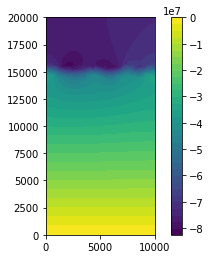

In [9]:
plt.figure()
pt = plot(p_n)
plt.colorbar(pt)
plt.show()

### Now I can calculate the velocity of the water phase

$$ \mathbf{v}_{w} = \frac{\lambda_{w}}{\rho_{w}}\left(\nabla p_{n} - \nabla p_{c} - \rho_{w}g\nabla z \right) $$

In [10]:
grav_w = Function(V)
grav_w.vector()[:] = z
vel = lw/rho_w*(grad(p_n) - grad(p_c)) - lw*grad(grav_w)

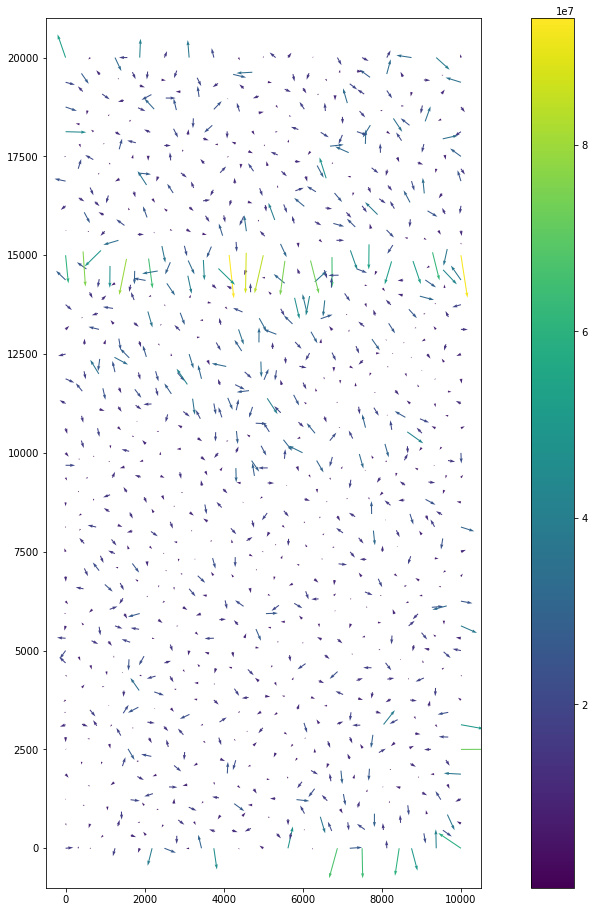

In [11]:
fig = plt.figure(figsize=(18, 16))
pl = plot(vel)
plt.colorbar(pl)
plt.show()

### Now calculate the saturation of water

$$ \phi\frac{\partial}{\partial t}\left( S_{w}\right) + \nabla\cdot\left(\mathbf{v}_{w}\right) = q_{w} $$

In [12]:
class East(SubDomain):
    def inside(self, x , on_boundary):
        return near(x[0], lx)
    
class West(SubDomain):
    def inside(self, x , on_boundary):
        return near(x[0], 0.0)
    
class North(SubDomain):
    def inside(self, x , on_boundary):
        return near(x[1], lz)
    
class South(SubDomain):
    def inside(self, x , on_boundary):
        return near(x[1], 0.0)
    
bc = [DirichletBC(V, S_w_D, South())]

In [13]:
S_w_n = TrialFunction(V)
vS = TestFunction(V)
phi = Constant(0.01)
dt = 1e-4

FS = ((S_w_n-S_w)/dt)*vS*dx + div(vel)/phi*vS*dx - q/phi*vS*dx
a, L = lhs(FS), rhs(FS)

# Compute solution
S_w_n = Function(V)
solve(a == L, S_w_n, bc)

# Update previous solution
S_w.assign(S_w_n)

Calling FFC just-in-time (JIT) compiler, this may take some time.


/home/armitage/anaconda3/lib/python3.7/site-packages/ffc/uflacs/analysis/dependencies.py:61: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  active[targets] = 1


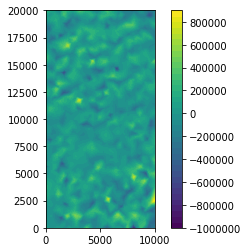

In [16]:
plt.figure()
pt = plot(div(vel))
plt.colorbar(pt)
plt.show()